# Build a conditional VAE on CIFAR-10 that can generate images of 10 classes

[Benchmark](https://paperswithcode.com/sota/image-generation-on-cifar-10)

Ref.

In [220]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_directml
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from typing import Type
from PIL import Image

## Setup device

In [221]:
for i in range(torch_directml.device_count()):
    print(i, ":", torch_directml.device_name(i))

dml = torch_directml.device(1)
print("dml =", dml)

device = dml

0 : Radeon RX 5500M
1 : AMD Radeon(TM) Graphics
dml = privateuseone:1


## Load data

In [222]:
training_data = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


## Variables

In [223]:
# Variables
classes = training_data.classes
class_size = len(classes)
channel_num = 3
image_size = 32
train_loss_history = []

# Hyperparameters
batch_size = 64
epochs = 100
latent_dim = 50
learning_rate = 1e-4
weight_decay = 0
embedding_dim = 10
evaluation = True

In [224]:
from torch.utils.data import DataLoader

training_data.data = training_data.data.astype("uint8")
test_data.data = test_data.data.astype("uint8")

kwargs = {"num_workers": 1, "pin_memory": True}

train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False, **kwargs)

## Show some samples

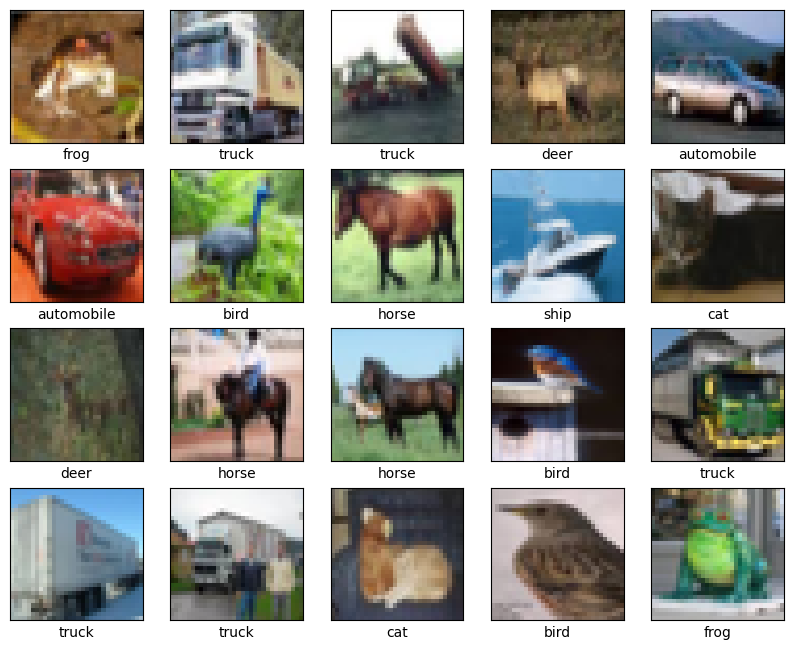

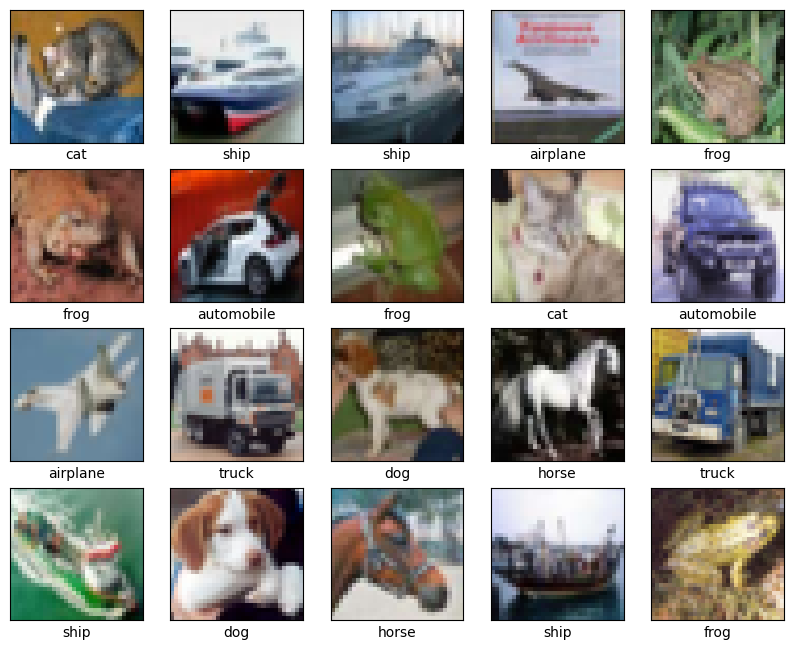

In [225]:
def show_cifar10_images(images, labels):
    plt.figure(figsize=[10, 10])

    for i in range(20):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(classes[labels[i]])

    plt.show()


show_cifar10_images(training_data.data, training_data.targets)
show_cifar10_images(test_data.data, test_data.targets)

## Data shape

In [226]:
print("Training images shape: ", training_data.data.shape)
print("Test images shape: ", test_data.data.shape)

Training images shape:  (50000, 32, 32, 3)
Test images shape:  (10000, 32, 32, 3)


## Build CVAE model

[cVAE mechanism](https://idiotdeveloper.com/introduction-to-autoencoders/)

![cVAE mechanism](./images/variational-autoencoder.png)

Ref.

[Understanding Conditional Variational Autoencoders](https://towardsdatascience.com/understanding-conditional-variational-autoencoders-cd62b4f57bf8)

[Conditional Variational Autoencoder (cVAE) using PyTorch](https://github.com/unnir/cVAE)

[Conditional Variational Autoencoder in Keras](https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb)

[GAN Evaluation : the Frechet Inception Distance and Inception Score metrics](https://colab.research.google.com/github/pytorch-ignite/pytorch-ignite.ai/blob/gh-pages/blog/2021-08-11-GAN-evaluation-using-FID-and-IS.ipynb#scrollTo=Stp59yfH65VO)
                                                                              
[Conditional Variational Autoencoders with Learnable Conditional Embeddings](https://towardsdatascience.com/conditional-variational-autoencoders-with-learnable-conditional-embeddings-e22ee5359a2a)
                                                                              
[Implementations/Conditional-Variational-Autoencoder/model.py](https://github.com/jaywonchung/Learning-ML/blob/master/Implementations/Conditional-Variational-Autoencoder/model.py)

### Loss function

In [227]:
def loss_function(recon_x, x, mu, logvar):
    """Reconstruction + KL divergence losses summed over all elements and batch

    See Appendix B from VAE paper:

    Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    https://arxiv.org/abs/1312.6114

    0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    """
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, image_size * image_size * channel_num), reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

### Encoder

In [228]:
class GaussianEncoder(nn.Module):
    """Gaussian encoder module for VAE"""

    def __init__(self, embedding_dim, latent_dim, conv_dims=[64, 128, 256], kernel_size=4):
        """
        Constructor for the GaussianEncoder class

        Parameter:
            embedding_dim: Dimension of embeded class
            latent_dim: Dimension of the latent variable
        """
        super().__init__()

        assert len(conv_dims) == 3

        self.latent_dim = latent_dim
        self.embedding_dim = embedding_dim
        self.conv_dims = conv_dims

        # x: (N, 3, 32, 32 + embedding_dim)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv_dims[0], kernel_size=kernel_size, stride=2, padding=1)
        # x: (N, 64, 16, (32 + embedding_dim) / 2)
        self.conv2 = nn.Conv2d(
            in_channels=conv_dims[0], out_channels=conv_dims[1], kernel_size=kernel_size, stride=2, padding=1
        )
        self.bn2 = nn.BatchNorm2d(num_features=conv_dims[1])
        # x: (N, 128, 8, (32 + embedding_dim) / 4)
        self.conv3 = nn.Conv2d(
            in_channels=conv_dims[1], out_channels=conv_dims[2], kernel_size=kernel_size, stride=2, padding=1
        )
        self.bn3 = nn.BatchNorm2d(num_features=conv_dims[2])
        # x: (N, 256, 4, (32 + embedding_dim) / 8)
        self.fc4 = nn.Linear(
            in_features=conv_dims[2] * 4 * int((32 + self.embedding_dim) / 8), out_features=2 * self.latent_dim
        )
        # x: (N, 2 * latent_dim)

        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                m.bias.data.fill_(0.0)

    def forward(self, x):
        """
        Forward method for the GaussianEncoder class

        Parameter:
            x: Batch of (images + onehot labels) => (N, 3, 32, 42).

        Return:
            mu: Vector of size latent_dim.
                Each element represents the mean of a Gaussian Distribution.
            sigma: Vector of size latent_dim.
                   Each element represents the standard deviation of a Gaussian distribution.
        """

        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = x.view(-1, self.conv_dims[2] * 4 * int((32 + self.embedding_dim) / 8))
        x = self.fc4(x)

        # split x in half
        mu = x[:, : self.latent_dim]
        # sigma shouldn't be negative
        sigma = 1e-6 + F.softplus(x[:, self.latent_dim :])

        return mu, sigma

### Decoder

In [229]:
class GaussianDecoder(nn.Module):
    """GaussianDecoder module for VAE"""

    def __init__(
        self,
        embedding_dim,
        latent_dim,
        model_sigma=False,
        deconv_dims=[256, 128, 64],
        kernel_size=4,
        first_latent_out_dims=[448, 2, 2],
    ):
        """
        Constructor for the GaussianDecoder class

        Parameter:
            embedding_dim: Dimension of embeded class
            latent_dim: Dimension of the latent variable
            model_sigma: Whether to model standard deviations too.
                         If False, only outputs the mu vector, and all sigma is implicitly 1.
        """
        super().__init__()

        assert len(deconv_dims) == 3
        assert len(first_latent_out_dims) == 3

        self.latent_dim = latent_dim
        self.embedding_dim = embedding_dim
        self.model_sigma = model_sigma
        self.first_latent_out_dims = first_latent_out_dims

        latent_out_dims = torch.prod(torch.Tensor(first_latent_out_dims)).int()

        # z: (N, latent_dim + 10)
        self.fc1 = nn.Linear(
            in_features=self.latent_dim + self.embedding_dim,
            out_features=latent_out_dims,
        )
        self.bn1 = nn.BatchNorm1d(num_features=latent_out_dims)
        # z: (N, 448 * 2 * 2)
        self.deconv2 = nn.ConvTranspose2d(
            in_channels=first_latent_out_dims[0],
            out_channels=deconv_dims[0],
            kernel_size=kernel_size,
            stride=2,
            padding=1,
        )
        self.bn2 = nn.BatchNorm2d(num_features=deconv_dims[0])
        # z: (N, 256, 4, 4)
        self.deconv3 = nn.ConvTranspose2d(
            in_channels=deconv_dims[0], out_channels=deconv_dims[1], kernel_size=kernel_size, stride=2, padding=1
        )
        # z: (N, 128, 8, 8)
        self.deconv4 = nn.ConvTranspose2d(
            in_channels=deconv_dims[1], out_channels=deconv_dims[2], kernel_size=kernel_size, stride=2, padding=1
        )
        # z: (N, 64, 16, 16)
        if model_sigma:
            self.deconv5 = nn.ConvTranspose2d(
                in_channels=deconv_dims[2], out_channels=6, kernel_size=kernel_size, stride=2, padding=1
            )
            # z: (N, 6, 32, 32)
        else:
            self.deconv5 = nn.ConvTranspose2d(
                in_channels=deconv_dims[2], out_channels=3, kernel_size=kernel_size, stride=2, padding=1
            )
            # z: (N, 3, 32, 32)

        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight)
                m.bias.data.fill_(0.0)

    def forward(self, z):
        """
        Forward method for the GaussianDecoder class

        Parameter:
            z: Batch of latent variables.

        Return:
            embedding_dim: Dimension of embeded class
            mu: Vector of size latent_dim.
                Each element represents the mean of a Gaussian Distribution.
            sigma: Vector of size latent_dim.
                   Each element represents the standard deviation of a Gaussian distribution.
        """

        z = F.relu(self.bn1(self.fc1(z)))
        z = z.view(-1, self.first_latent_out_dims[0], self.first_latent_out_dims[1], self.first_latent_out_dims[2])
        z = F.relu(self.bn2(self.deconv2(z)))
        z = F.relu(self.deconv3(z))
        z = F.relu(self.deconv4(z))
        if self.model_sigma:
            gaussian = self.deconv5(z)
            mu = torch.sigmoid(gaussian[:, :3, :, :]).unsqueeze(1)
            sigma = 1e-6 + F.softplus(gaussian[:, 3:, :, :]).unsqueeze(1)
            return mu, sigma
        else:
            mu = torch.sigmoid(self.deconv5(z))
            return mu

### CVAE

In [230]:
from torchinfo import summary


class CVAE(nn.Module):
    """Conditional Variational Autoencoder module that wraps one encoder and one decoder module."""

    def __init__(
        self,
        embedding_dim,
        latent_dim,
        model_sigma=False,
        device="cpu",
        conv_dims=[64, 128, 256],
        deconv_dims=[256, 128, 64],
        conv_kernel_size=4,
        deconv_kernel_size=4,
    ):
        """
        Constructor for VAE class

        Parameter:
            embedding_dim: Dimension of embeded class
            latent_dim: Dimension of the latent variable
            model_sigma: Whether to model standard deviations too.
                         If True, forward method returns (mu, sigma). Else, returns only mu.
            device: the device to use for conv_y
        """
        super().__init__()
        self.latent_dim = latent_dim
        self.embedding_dim = embedding_dim
        self.model_sigma = model_sigma
        self.device = device

        self.encoder = GaussianEncoder(self.embedding_dim, self.latent_dim, conv_dims, conv_kernel_size)
        self.decoder = GaussianDecoder(
            self.embedding_dim, self.latent_dim, self.model_sigma, deconv_dims, deconv_kernel_size
        )
        self.embed_cond = nn.Embedding(num_embeddings=class_size, embedding_dim=embedding_dim, max_norm=True)

    def forward(self, x, y):
        """
        Forward method for the GaussianEncoder class
        Samples latent variable z from the distribution calculated by the encoder,
        and feeds it to the decoder

        Parameter:
            x: Batch of images => (N, 3, 32, 32).
            y: Label of batch.

        Return:
            If model_sigma is True, returns (z_mu, z_sigma, mu, sigma)
            Else, returns (z_mu, z_sigma, mu)
        """
        y = torch.Tensor(y).int()
        y = self.embed_cond(y)
        y = y.view(-1, embedding_dim)

        # Encode
        conv_y = y.view(-1, 1, 1, self.embedding_dim) * torch.ones(
            (x.shape[0], x.shape[1], x.shape[2], self.embedding_dim)
        ).to(self.device)
        input_batch = torch.cat((x, conv_y), dim=3)
        z_mu, z_sigma = self.encoder(input_batch)
        self.z = z_mu + z_sigma * torch.randn_like(z_mu)  # reparametrization trick

        # Decode
        latent = torch.cat((self.z, y), dim=1)
        mu = self.decoder(latent)
        return (z_mu, z_sigma) + (mu,)

    def generate_images(self, repeat_size):
        """從隨機分布中生成指定數量的圖片"""

        with torch.no_grad():
            # 生成對稱數量的 classes (one hot)
            # c = torch.eye(gen_size, class_size).to(device)

            y = torch.Tensor(np.tile(np.arange(class_size), repeat_size)).to(device).int()

            # 隨機生成分布
            noises_z = torch.randn(repeat_size * class_size, latent_dim).to(device)

            latent = torch.cat((noises_z, self.embed_cond(y)), dim=1)

            samples = self.decoder(latent)
            # gen_images = samples.view(repeat_size * class_size, channel_num, image_size, image_size)

            return samples.cpu(), y

In [231]:
model = CVAE(
    embedding_dim=embedding_dim,
    latent_dim=latent_dim,
    model_sigma=False,
    device=device,
    conv_dims=[32, 64, 128],
    deconv_dims=[128, 64, 32],
    conv_kernel_size=4,
    deconv_kernel_size=4,
).to(device)

summary_model = CVAE(embedding_dim=embedding_dim, latent_dim=latent_dim, model_sigma=False, device="cpu").to("cpu")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

summary(
    summary_model,
    input_size=[(batch_size, channel_num, image_size, image_size), [batch_size]],
    device="cpu",
)

Layer (type:depth-idx)                   Output Shape              Param #
CVAE                                     [64, 50]                  --
├─Embedding: 1-1                         [64, 10]                  100
├─GaussianEncoder: 1-2                   [64, 50]                  --
│    └─Conv2d: 2-1                       [64, 64, 16, 21]          3,136
│    └─Conv2d: 2-2                       [64, 128, 8, 10]          131,200
│    └─BatchNorm2d: 2-3                  [64, 128, 8, 10]          256
│    └─Conv2d: 2-4                       [64, 256, 4, 5]           524,544
│    └─BatchNorm2d: 2-5                  [64, 256, 4, 5]           512
│    └─Linear: 2-6                       [64, 100]                 512,100
├─GaussianDecoder: 1-3                   [64, 3, 32, 32]           --
│    └─Linear: 2-7                       [64, 1792]                109,312
│    └─BatchNorm1d: 2-8                  [64, 1792]                3,584
│    └─ConvTranspose2d: 2-9              [64, 256, 4, 4]

### Training

In [232]:
def train_step(epoch, data_loader: Type[DataLoader]):
    model.train()
    train_loss = 0
    loss = torch.Tensor()
    current_data_len = 0

    for batch_idx, (data, labels) in enumerate(data_loader):
        data, labels = data.to(device), labels.to(device)
        current_data_len = len(data)

        optimizer.zero_grad()

        mu, sigma, recon_batch = model(data, labels)
        recon_batch = recon_batch.view(-1, channel_num * image_size * image_size)
        loss = loss_function(recon_batch, data, mu, sigma)
        loss.backward()
        train_loss += loss.detach().cpu().numpy()

        optimizer.step()

        # log
        if batch_idx % 20 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    (batch_idx + 1) * len(data),
                    len(data_loader.dataset),
                    100.0 * (batch_idx + 1) / len(data_loader),
                    loss.item() / len(data),
                ),
                end="\r",
            )

            n = min(data.size(0), 5)
            comparison = torch.cat([data[:n], recon_batch.view(-1, channel_num, image_size, image_size)[:n]])
            save_image(
                comparison.cpu(),
                "./outputs/cifar-10-cvae-outputs/temp/gen/reconstruction_" + str(f"{epoch:02}") + ".png",
                nrow=n,
            )

    # Last batch of this epoch
    print(
        "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
            epoch,
            len(data_loader.dataset),
            len(data_loader.dataset),
            100,
            loss.item() / current_data_len,
        ),
        end="\r\n",
    )

    # Calculate average loss of this epoch
    train_loss /= len(data_loader.dataset)
    train_loss_history.append(train_loss)

    print("====> Epoch: {} Average loss: {:.4f}".format(epoch, train_loss))


for epoch in range(1, epochs + 1):
    train_step(epoch, train_loader)
    mu, labels = model.generate_images(1)
    save_image(
        mu,
        "./outputs/cifar-10-cvae-outputs/temp/gen/sample_" + str(f"{epoch:02}") + ".png",
    )

Train Epoch: 1 [50000/50000 (100%)]	Loss: 1823.031616
====> Epoch: 1 Average loss: 1913.1168
Train Epoch: 2 [50000/50000 (100%)]	Loss: 1917.630737
====> Epoch: 2 Average loss: 1810.7675
Train Epoch: 3 [50000/50000 (100%)]	Loss: 1756.552979
====> Epoch: 3 Average loss: 1794.4846
Train Epoch: 4 [50000/50000 (100%)]	Loss: 1831.161011
====> Epoch: 4 Average loss: 1785.4279
Train Epoch: 5 [50000/50000 (100%)]	Loss: 1837.901733
====> Epoch: 5 Average loss: 1780.0065
Train Epoch: 6 [50000/50000 (100%)]	Loss: 1863.019531
====> Epoch: 6 Average loss: 1775.9912
Train Epoch: 7 [50000/50000 (100%)]	Loss: 1763.289185
====> Epoch: 7 Average loss: 1774.0323
Train Epoch: 8 [50000/50000 (100%)]	Loss: 1852.638672
====> Epoch: 8 Average loss: 1772.0876
Train Epoch: 9 [50000/50000 (100%)]	Loss: 1826.332031
====> Epoch: 9 Average loss: 1770.5575
Train Epoch: 10 [50000/50000 (100%)]	Loss: 1772.992065
====> Epoch: 10 Average loss: 1769.1703
Train Epoch: 11 [50000/50000 (100%)]	Loss: 1794.219238
====> Epoch: 

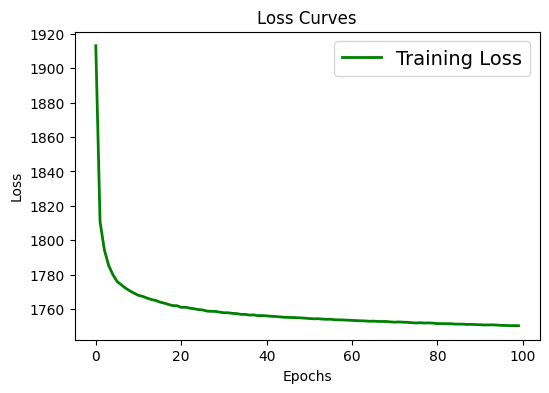

In [233]:
plt.figure(figsize=[6, 4])
plt.plot(train_loss_history, "green", linewidth=2.0)
plt.legend(["Training Loss"], fontsize=14)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Loss", fontsize=10)
plt.title("Loss Curves", fontsize=12)
plt.show()

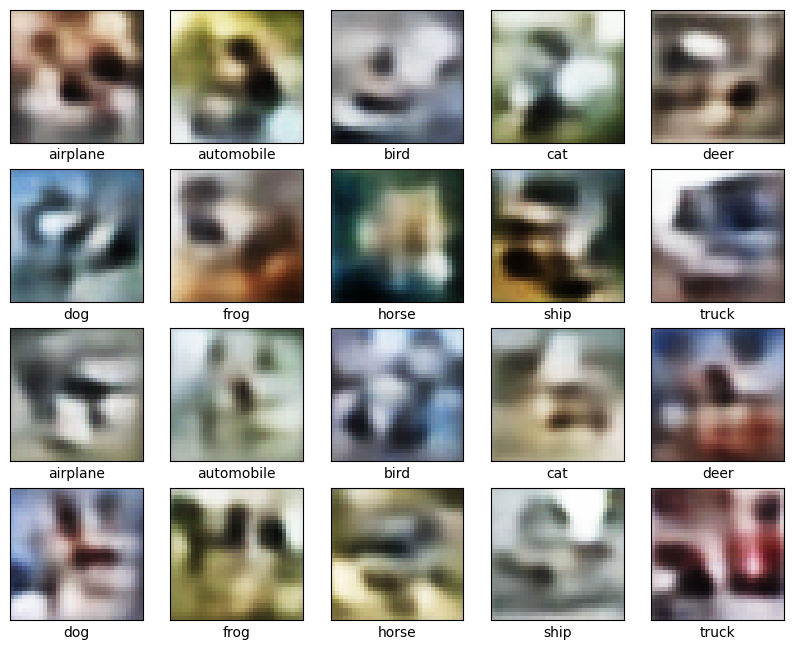

In [234]:
repeat_size = 1000
gen_images, gen_labels = model.generate_images(repeat_size)

save_image(
    gen_images[:10],
    "./outputs/cifar-10-cvae-outputs/temp/gen/evaluation.png",
)

pil_img = []

for img in gen_images:
    pil_img.append(transforms.ToPILImage()(img))

show_cifar10_images(pil_img, gen_labels)

## FID evaluation

Ref.

Inception v3 architecture

![Inception v3 architecture](./images/inception_v3.png)

[GAN in Pytorch with FID](https://www.kaggle.com/code/ibtesama/gan-in-pytorch-with-fid#References)

In [235]:
if evaluation:
    from torcheval.metrics.image import FrechetInceptionDistance

    def interpolate(images):
        """
        Inception v3 model 需要輸入為 299 * 299 * 3
        所以需要先將 32 * 32 * 3 的 cifar-10 資料重新調整大小
        """
        stack = []

        for img in images:
            pil_img = transforms.ToPILImage()(img)
            resized_img = pil_img.resize((299, 299), Image.BILINEAR)
            stack.append(transforms.ToTensor()(resized_img))

        return torch.stack(stack)

    fid_metric = FrechetInceptionDistance().to("cpu")

    def fid_evaluation(real, gen):

        gen = interpolate(gen)
        real = interpolate(real)

        fid_metric.update(real, is_real=True)
        fid_metric.update(gen, is_real=False)
        fid = fid_metric.compute()
        fid_metric.reset()

        return fid

    fids = []

    for batch_idx, (data, labels) in enumerate(test_loader):

        fid = fid_evaluation(data, gen_images[batch_idx * 1000 : (batch_idx * 1000) + 1000])
        fids.append(fid)

        print(
            "FID Evaluation: [{}/{} ({:.0f}%)]\tFID: {:.6f}".format(
                (batch_idx + 1) * len(data), len(test_loader.dataset), 100.0 * (batch_idx + 1) / len(test_loader), fid
            ),
            end="\r",
        )

    print("\nAverage FID:", np.mean(fids))

FID Evaluation: [10000/10000 (100%)]	FID: 101.474152
Average FID: 100.754005


## Save model state dict

In [236]:
# torch.save(model.state_dict(), './models/state_dict/cifar-10-cvae-training-3.pth')

### Load model and using decoder

In [240]:
model = CVAE(
    embedding_dim=embedding_dim,
    latent_dim=latent_dim,
    model_sigma=False,
    device=device,
    conv_dims=[32, 64, 128],
    deconv_dims=[128, 64, 32],
    conv_kernel_size=4,
    deconv_kernel_size=4,
).to(device)

state = torch.load("./models/state_dict/cifar-10-cvae-training-3.pth")

model.load_state_dict(state)

<All keys matched successfully>

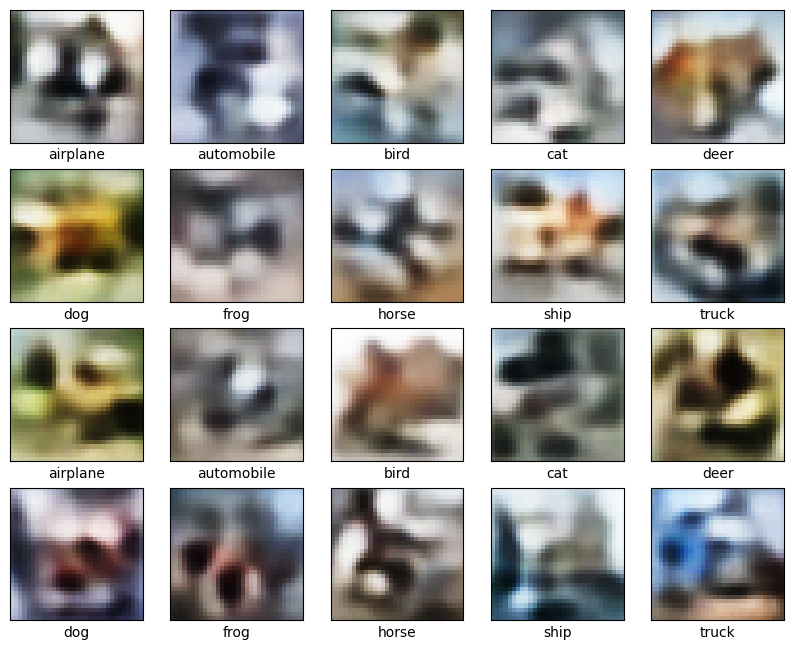

In [255]:
gen_images, gen_labels = model.generate_images(1000)

pil_img = []

for img in gen_images:
    pil_img.append(transforms.ToPILImage()(img))

show_cifar10_images(pil_img, gen_labels)